### Visualisation Notebook
This notebook serves as a comprehensive resource for generating plots featured in the manuscript, as well as providing additional visualizations for data analysis and interpretation.

Key points include:

- All scripts used to produce the manuscript's plots are included in this notebook.
- Additional plots are available to facilitate further exploration and analysis of the data.
- The code for the plotting functions is modularized and stored separately in the plotting_functions.py file for ease of use and maintenance.


In [1]:

#This two functions are used to get the number of fragments per group and the top fragments per group for each library

import pandas as pd

def get_fragments_per_group(df_list: list, library_names: list, group_col: str, count_col) -> pd.DataFrame:
    new_df = pd.DataFrame()
    for i, df in enumerate(df_list):
        # add the number of unique elements from the count column with each group
        new_row = df.groupby(group_col).agg({count_col: 'nunique'}).reset_index()
        # rename count column
        new_row.rename(columns={count_col: 'count'}, inplace=True)
        new_row['library'] = library_names[i]
        new_df = pd.concat([new_df, new_row])
        
    # Sort the dataframe by the count column
    new_df.sort_values(by='count', ascending=False, inplace=True)
        
    return new_df


def get_top_fragments_per_group(df_list: list, library_names: list, group_col: str, value_col:str, number_of_top: int=10) -> pd.DataFrame:
    new_df = pd.DataFrame()
    for i, df in enumerate(df_list):
        df['library'] = library_names[i]
        df = df[[group_col, value_col, 'library','LUTnr', 'Peptide', 'Sequence']]
        new_df = pd.concat([new_df, df])
    new_df.sort_values(by=[group_col,value_col], ascending=[True,False], inplace=True)
    # add the number of top number of rows with the highest values from the value column with each group
    temp_df = new_df.groupby(group_col).apply(lambda x: x.nlargest(number_of_top, value_col)).reset_index(drop=True)
        
    # Sort the dataframe by the count column
    temp_df.sort_values(by=[group_col,value_col], ascending=[True,False], inplace=True)
    
    return temp_df

In [1]:
# Read the dataframes into dataframes

import pandas as pd

df_p005 = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p005/final_fragments_summary.csv")
df_p006 = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p006/final_fragments_summary.csv")
df_p007 = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p007/final_fragments_summary.csv")

In [ ]:
# Analyze the dataframes to see the number of fragments that have more than one barcode matching to them
def barcode_counts_analysis(df: pd.DataFrame, group_col: str, count_col: str) -> pd.DataFrame:
    # for each Group show the number of fragments that have a BC_count > 1 and 1 
    df['BC_count_label'] = df[count_col].apply(lambda x: 'BC_count > 1' if x > 1 else 'BC_cout = 1')
    # for each group get the number of fragments that have a BC_count > 1 and 1
    return df.groupby(group_col).agg({'BC_count_label': 'value_counts'}).unstack().fillna(0)

barcode_counts_analysis(df_p005, 'Group', 'BC_count')

barcode_counts_analysis(df_p006, 'Group', 'BC_count')

barcode_counts_analysis(df_p007, 'Group', 'BC_count')


BC_count_label            
BC_count_label         BC_count > 1 BC_cout = 1
Group                                          
Cerebellum                      1.0       220.0
Corpus_callosum                 1.0       158.0
DNAse_resistant_AAVs        28223.0     30016.0
Fimbria                         2.0       439.0
Forebrain_ventricle             1.0        75.0
Infective_AAVs               3171.0     15760.0
Medulla                         7.0       440.0
Optic_tract                    12.0       618.0
Plasmid_Library             95247.0      8655.0
Posterior_commisure             0.0        40.0
Sox10+_IC                     231.0      4617.0
Sox10+_midbrain                18.0      1209.0
Sox10+_sort_pooled            213.0      3888.0
Sox10+_striatum               304.0      5509.0
Sox10-_IC                     246.0      4361.0
Sox10-_sort_pooled             39.0      1887.0
Sox10-_striatum               477.0      6773.0
Stria_medularis                 1.0        94.0
Striatal_ventricle              0.0        39.0

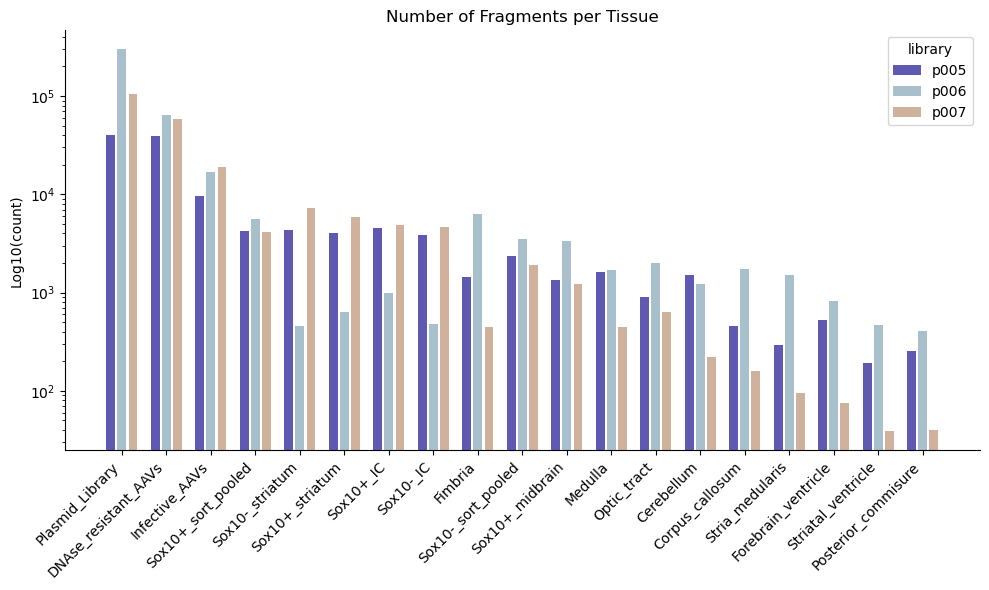

In [5]:
# Here we are using the plotting function that we have created to plot the number of fragments per group for each library

from plotting_functions import create_grouped_barplot

count_df = get_fragments_per_group([df_p005, df_p006, df_p007], ['p005', 'p006', 'p007'], 'Group', 'Peptide')

plot = create_grouped_barplot(count_df, 'Group', 'count', 'library')
# save the plot as a png file without background
plot.savefig("plots/librarys/fragments_per_tissue_comparison.png", dpi=300, bbox_inches='tight', transparent=True)

In [9]:
# Here we chose the number of top fragments that we want for each group and the value column that we want to use
# Then we create a new dataframe with the top fragments for each group and save it to a csv file

top_nr = 30
value_col = 'RNAcount_ratio' #'BC_adjusted_count_ratio' or 'RNAcount' or 'BC_count' or 'RNAcount_ratio'
top_df = get_top_fragments_per_group([df_p005, df_p006, df_p007],["p005", "p006", "p007"], 'Group', value_col, top_nr)
top_df.to_csv(f"plots/tops/top_{top_nr}_{value_col}_fragments.csv", index=False)

/tmp/ipykernel_196433/2611801474.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temp_df = new_df.groupby(group_col).apply(lambda x: x.nlargest(number_of_top, value_col)).reset_index(drop=True)


### Library-Specific Plots
This section focuses on generating plots tailored to specific libraries. The visualizations can be customized by selecting different datasets (dataframes) representing the libraries. Users can modify the code to switch between libraries as needed, enabling flexibility in analysis and presentation.

In [10]:
# checking the number of fragments that overlap between the libraries
# Define the input file (regular FASTQ, not gzipped)
input_p005 = "/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p005/SortedFragments.txt"
input_p007 = "/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p007/SortedFragments.txt"
# Extract sequences
sequences_p005 = []
sequences_p007 = []

with open(input_p005, "r") as handle:  # Use open instead of gzip.open
    # Read the file line by line
    for line in handle:
        # Remove leading/trailing whitespaces
        line = line.strip()
        # Skip empty lines
        if not line:
            continue
        # Skip header lines
        if line.startswith("S"):
            continue
        # Store the sequence
        sequences_p005.append(line)
        
with open(input_p007, "r") as handle: 
    for line in handle:
        line = line.strip()
        if not line:
            continue
        if line.startswith("S"):
            continue
        sequences_p007.append(line)
        
print(f"Number of sequences in p005: {len(sequences_p005)}")
print(f"Number of sequences in p007: {len(sequences_p007)}")

# confert list to a set
sequences_p005 = set(sequences_p005)
sequences_p007 = set(sequences_p007)

# Find the intersection
common_sequences = sequences_p005.intersection(sequences_p007)
print(f"Number of common sequences: {len(common_sequences)}")

Number of sequences in p005: 41980
Number of sequences in p007: 117126
Number of common sequences: 32403


In [1]:
# Read the dataframes into dataframes

import pandas as pd

df_p005 = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p005/final_fragments_summary.csv")
df_p006 = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p006/final_fragments_summary.csv")
df_p007 = pd.read_csv("/lunarc/nobackup/projects/lu2024-17-19/J_rAAven/BRAVE/raav-60/p007/final_fragments_summary.csv")

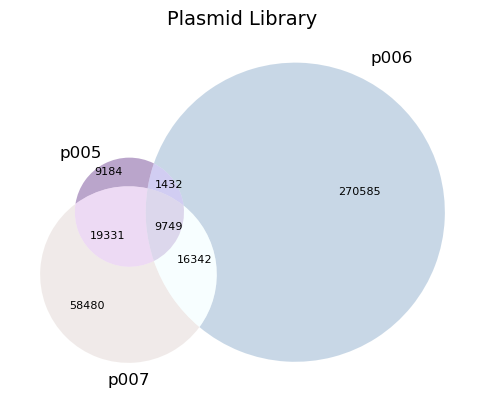

In [2]:
from plotting_functions import plot_venn_diagram
# Get the number of Peptides we actually have in the libraries
p005_Plasmid_Library = set(df_p005[df_p005['Group'] == 'Plasmid_Library']['Peptide'])
p006_Plasmid_Library = set(df_p006[df_p006['Group'] == 'Plasmid_Library']['Peptide'])
p007_Plasmid_Library = set(df_p007[df_p007['Group'] == 'Plasmid_Library']['Peptide'])

plot_venn_diagram(p005_Plasmid_Library, p006_Plasmid_Library, p007_Plasmid_Library, ('p005', 'p006', 'p007'), 'Plasmid Library')


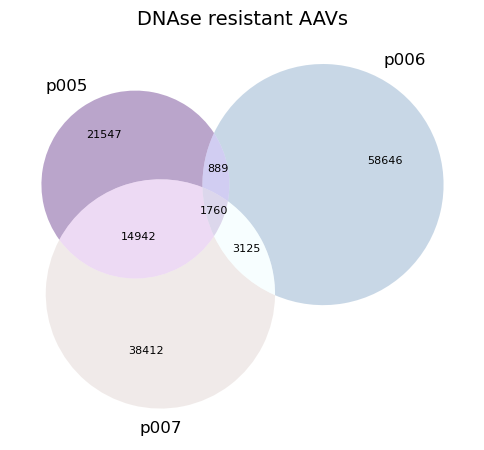

In [3]:
from plotting_functions import plot_venn_diagram
# Get the number of Peptides we have found in the DNAse resistant library
p005_DNAse_resistant = set(df_p005[df_p005['Group'] == 'DNAse_resistant_AAVs']['Peptide'])
p006_DNAse_resistant = set(df_p006[df_p006['Group'] == 'DNAse_resistant_AAVs']['Peptide'])
p007_DNAse_resistant = set(df_p007[df_p007['Group'] == 'DNAse_resistant_AAVs']['Peptide'])

plot_venn_diagram(p005_DNAse_resistant, p006_DNAse_resistant, p007_DNAse_resistant, ('p005', 'p006', 'p007'), 'DNAse resistant AAVs')

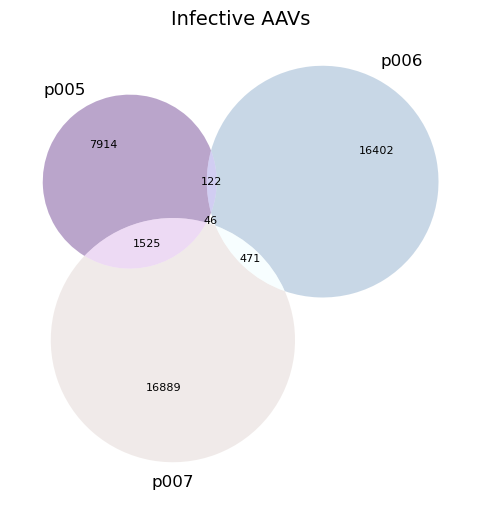

In [4]:
from plotting_functions import plot_venn_diagram
# Get the number of Peptides we have found in the Infective AAVs library
p005_Infective_AAVs = set(df_p005[df_p005['Group'] == 'Infective_AAVs']['Peptide'])
p006_Infective_AAVs = set(df_p006[df_p006['Group'] == 'Infective_AAVs']['Peptide'])
p007_Infective_AAVs = set(df_p007[df_p007['Group'] == 'Infective_AAVs']['Peptide'])

plot_venn_diagram(p005_Infective_AAVs, p006_Infective_AAVs, p007_Infective_AAVs, ('p005', 'p006', 'p007'), 'Infective AAVs')


In [30]:
# Selecting the data that we want to use for the plot

df = df_p007
# for p005 we can extract the GeneName from the Origion_seq column
if df['Origion_seq'].str.contains(',').any():
    df['GeneName'] = df['Origion_seq'].str.split(',').str[5]

In [28]:
# Here we creating a new dataframe that holds the number of unique variants in each group

# get the number of unique LUTnr in each group of the dataframe
df.groupby('Group')['LUTnr'].nunique().sort_values(ascending=False)

# create a new dataframe with Group and number of fragments in that group
group_df = df.groupby('Group').size().reset_index(name='count')

# Sort the dataframe by the count column in descending order
group_df.sort_values(by='count', ascending=False, inplace=True)

# Check if Infectiv_AAV is a subset of DNA_resistant_AAV and DNA_sensitive_AAV is a subset of Plasmid_library 
# get a set of all unique Sequences in the three groups
Infectiv_AAV = set(df[df['Group'] == 'Infective_AAVs']['LUTnr'])
DNA_resistant_AAV = set(df[df['Group'] == 'DNAse_resistant_AAVs']['LUTnr'])
Plasmid_library = set(df[df['Group'] == 'Plasmid_Library']['LUTnr'])

# add that summary to the group_df
group_df.loc[len(group_df)] = ['Infectiv_AAV in DNA_resistant_AAV', f'{len(Infectiv_AAV.intersection(DNA_resistant_AAV))} ({(len(Infectiv_AAV.intersection(DNA_resistant_AAV))/len(Infectiv_AAV)):.4f}%)']
group_df.loc[len(group_df)] = ['Infectiv_AAV in Plasmid_library', f'{len(Infectiv_AAV.intersection(Plasmid_library))} ({(len(Infectiv_AAV.intersection(Plasmid_library))/len(Infectiv_AAV)):.1f}%)']
group_df.loc[len(group_df)] = ['DNA_resistant_AAV in Plasmid_library', f'{len(DNA_resistant_AAV.intersection(Plasmid_library))} ({(len(DNA_resistant_AAV.intersection(Plasmid_library))/len(DNA_resistant_AAV)):.1f}%)']

# save the dataframe to a csv file
group_df.to_csv("plots/librarys/p005_fragments_per_group.csv", index=False)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


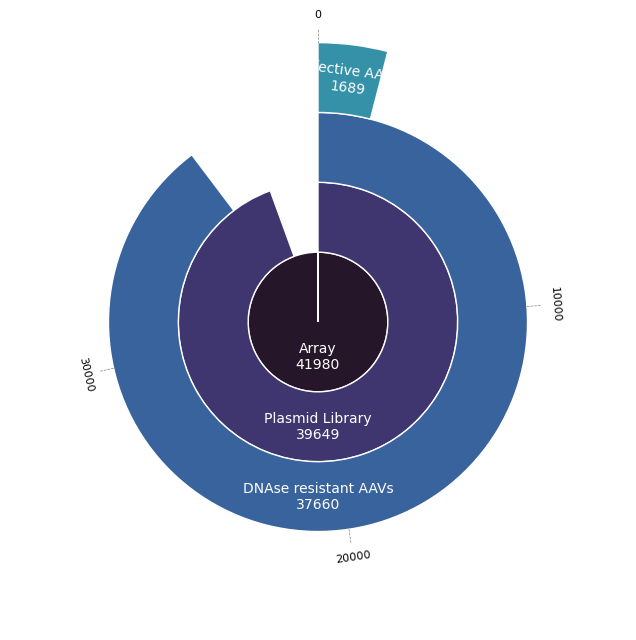

In [7]:
# Here we are using the plotting function that we have created to plot the number of fragments per group for each library to show the distribution of fragments in each group

from plotting_functions import plot_quantities

plot = plot_quantities(df_p005_filtered,
                {'Plasmid_Library':'Plasmid Library', 'DNAse_resistant_AAVs':'DNAse resistant AAVs', 'Infective_AAVs': 'Infective AAVs'},
                {"Array": 41980}, step_size=10000)
# Arrays p005:41980 p007:117126

#plot.savefig("plots/librarys/p005_quantities.png", dpi=300, bbox_inches='tight', transparent=True)

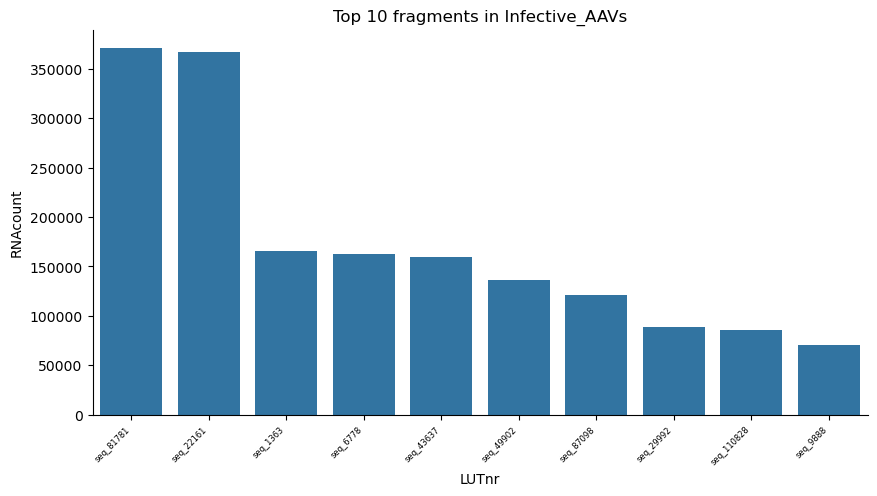

In [31]:
# Here we are using the plotting function that we have created to plot with the read count ratio for the top fragments in a specific group

from plotting_functions import plot_top_counts

plot_top_counts(df, 10, 'Infective_AAVs', 'RNAcount', )

# Save the plot as a png file without background
plot.savefig("plots/librarys/p007_top_counts.png", dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
# Here we are getting an overview of the unique group names and gene names in the dataframe

# print all unique group names
print(df['Group'].unique())
# print all unqiue gene names
print(df['GeneName'].unique())

In [ ]:
# Here we are plotting the normalized RNA counts comparison between two gropus accros a specific gene reference

from plotting_functions import plot_rna_counts
import numpy as np

df['normalized_RNAcount'] = np.log2(df['RNAcount']+1)
plot_rna_counts(df, "Plasmid_Library", "Infective_AAVs", "AAV1-VP1", "RNAcount", "RNA count", normalize=True)

# Save the plot as a png file without background
plot.savefig("plots/librarys/p005_rna_counts_comparison.png", dpi=300, bbox_inches='tight', transparent=True)


In [22]:
# Here is a function that is used to get the top fragments for a specific group and structure

def get_top_fragment(df, group, n, sort_by, strucutre=None):
    if strucutre is None:
        return df[df['Group'] == group].nlargest(n, sort_by)
    else:
        return df[(df['Group'] == group) & (df['Structure'] == strucutre)].nlargest(n, sort_by)

In [24]:
# Here we are using the function to get the top 50 fragments for a specific group and structure

top_50_inf_aavs = get_top_fragment(df, "Infective_AAVs", 50, "BC_adjusted_count_ratio")

In [ ]:
# here we are plotting the heatmap for amino acid usage for a specific group

from plotting_functions import plot_amino_acid_heatmap

plot_amino_acid_heatmap(top_50_inf_aavs, "Infective_AAVs")